In [424]:
import sys
import numpy as np
# import scikitlearn
import matplotlib.pyplot as plt
import pandas as pd
import glob

# ML Magic:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import (
    train_test_split,
    KFold
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error
)

from sklearn.preprocessing import (
    StandardScaler,
    Normalizer,
    MinMaxScaler
)

# Local includes:
sys.path.append("../../src/")
import therm_params as tp
from power_model import (
    leakagePower,
    peripheral_power,
    board_power
)


In [337]:
# blackscholes_files = glob.glob("../blackscholes_benchmarking/*.csv")
blackscholes_files = ["../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"]
bodytrack_files = glob.glob("../bodytrack_benchmarking/*.csv")
# random_data = ["../bodytrack_benchmarking/random_mc1_4_log_4_1_2018.csv"]
random_data = ["../bodytrack_benchmarking/xu4_random_loads_4_1_2018.csv"]
files = random_data

In [363]:
df_list = []

def leak_row_big(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_big_cluster, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)
    
def leak_row_little(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_little_cluster, \
            np.mean( [row.temp4, row.temp5, row.temp6, row.temp7, row.temp_gpu] ) + 273.15)

def leak_row_gpu(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_gpu, row.temp_gpu + 273.15 )

def leak_row_mem(row):
    return leakagePower(tp.c1, tp.c2, tp.Igate, row.volts_mem, \
            np.max( [row.temp4, row.temp5, row.temp6, row.temp7] ) + 273.15)

for file in files:
    df = pd.read_csv(file, index_col=False, header=0, sep='\t')
    df_list.append(df)

def process_dataframe_list(df_list):
    data = pd.concat(df_list, ignore_index=True)
    # Drop all measurements where watts <= 0:
    data = data.loc[data.watts > 0]
    # fill in the potentially missing voltage values
    data["volts_big_cluster"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000])
    data["volts_little_cluster"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000])
    # Replace with correct value for gpu and mem voltage:
    data["volts_gpu"] = 1.0
    data["volts_mem"] = 1.2
    # Recompute the leakage power:
    data['leak_big'] = data.apply(leak_row_big, axis=1)
    data['leak_little'] = data.apply(leak_row_little, axis=1)
    data['leak_gpu'] = data.apply(leak_row_gpu, axis=1)
    data['leak_mem'] = data.apply(leak_row_mem, axis=1)
    data['w_leak2'] = data.apply(lambda row: np.sum( [row.leak_big, row.leak_little, row.leak_gpu, row.leak_mem] ), axis=1)

    data_filtered = pd.DataFrame()
    data_filtered["usage_little"] = data[["usage_c0", "usage_c1", "usage_c2", "usage_c3"]].apply(func = np.sum, axis=1)
    data_filtered["usage_big"] = data[["usage_c4", "usage_c5", "usage_c6", "usage_c7"]].apply(func = np.sum, axis=1)
    data_filtered["max_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.max, axis=1)
    data_filtered["avg_temp_big"] = data[["temp4", "temp5", "temp6", "temp7"]].apply(func = np.mean, axis=1)
    data_filtered["gpu_temp"] = data.temp_gpu
    data_filtered["vvf_b"] = data.freq_big_cluster.map(lambda x: tp.big_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["vvf_l"] = data.freq_little_cluster.map(lambda x: tp.little_f_to_v[float(x)/1000000000]**2 * x)
    data_filtered["p_dyn"] = data.apply(lambda row: row.watts - row.w_leak2 - peripheral_power, axis=1)
    data_filtered["aVVFb"] = data_filtered.apply(lambda row: row.usage_big * row.vvf_b, axis=1)
    data_filtered["aVVFl"] = data_filtered.apply(lambda row: row.usage_little * row.vvf_l, axis=1)
    data_filtered["gpu_mem"] = 1
    data_filtered['p_total'] = data.watts
    data_filtered['p_leak'] = data.w_leak2
    data_filtered['leak_big'] = data.leak_big
    data_filtered['leak_little'] = data.leak_little
    data_filtered.dropna(axis=0, how='any', inplace=True)
    # Sanity check:
    min_p_dyn = np.min(data_filtered.p_dyn.loc[data_filtered['p_dyn'] < 0])
    if not pd.isnull(min_p_dyn):
        data_filtered -= min_p_dyn
    return data_filtered

In [341]:
data_filtered = process_dataframe_list(df_list)
data_filtered.describe()

,usage_little,usage_big,max_temp_big,avg_temp_big,gpu_temp,vvf_b,vvf_l,p_dyn,aVVFb,aVVFl,gpu_mem,p_total,p_leak
count,287005.000000,287005.000000,287005.000000,287005.000000,287005.000000,2.870050e+05,2.870050e+05,287005.000000,2.870050e+05,2.870050e+05,287005.000000,287005.000000,287005.000000
mean,0.380583,0.506857,46.281154,44.727368,41.867674,1.283877e+09,9.062659e+08,0.609851,5.487060e+08,3.355169e+08,1.002846,3.114105,0.253099
std,0.604539,0.706384,5.152665,4.177167,2.832481,9.096008e+08,6.180996e+08,0.676893,9.578337e+08,6.912436e+08,0.000000,0.717119,0.044864
min,0.002846,0.002846,39.002846,38.252846,36.002846,1.620000e+08,1.620000e+08,0.000000,2.845555e-03,2.845555e-03,1.002846,2.479846,0.189538
25%,0.002846,0.002846,43.002846,41.752846,40.002846,4.860000e+08,4.050000e+08,0.180498,2.845555e-03,2.845555e-03,1.002846,2.659846,0.225134
50%,0.002846,0.102846,45.002846,43.752846,41.002846,1.045688e+09,8.000000e+08,0.370264,1.070595e+08,2.845555e-03,1.002846,2.865846,0.242610
75%,1.002846,1.002846,48.002846,46.502846,44.002846,1.980250e+09,1.361422e+09,0.764001,6.642000e+08,3.240000e+08,1.002846,3.277846,0.265442
max,4.002846,4.002846,81.002846,73.502846,56.002846,3.380000e+09,2.187500e+09,9.686610,1.287546e+10,7.394400e+09,1.002846,12.414846,0.623567


In [425]:
X = data_filtered.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"]]
y = data_filtered.p_total
# Or:
# y = data_filtered.p_dyn

# Fit and apply a scaler to the data:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# Estimate C values for the model (built-in cross validation):
DPM = RidgeCV(alphas = np.linspace(0.001, 100, 100), cv=5, normalize=False, fit_intercept=True)
# # Create training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True) 
DPM = DPM.fit(X_train,y_train)
P = DPM.predict(X_test)

In [426]:
R = DPM.score(X_test, y_test)
R

0.88890398338186061

In [427]:
mean_squared_error( list(y_test.values), list(P) )

0.056864148008960141

In [428]:
pd.DataFrame([list(P), list(y_test.values)] )

,0,1,2,3,4,5,6,7,8,9,...,86092,86093,86094,86095,86096,86097,86098,86099,86100,86101
0,3.452082,2.778574,2.545991,3.021438,3.027598,2.700445,2.504939,2.800187,2.844339,2.757007,...,2.663659,2.768069,3.170588,2.821839,3.544998,3.322294,4.789817,3.003491,3.216050,2.813497
1,3.468846,2.693846,2.617846,2.842846,3.197846,2.697846,2.536846,2.781846,2.659846,2.620846,...,2.643846,2.685846,3.029846,2.674846,3.609846,3.246846,4.502846,2.807846,3.326846,2.670846


In [429]:
# Load some other data and test/plot it:
# f_test = "../blackscholes_benchmarking/userspace_ondemand_blackscholes.csv"
# Or:
f_test = "../bodytrack_benchmarking/userspace_ondemand_bodytrack.csv"

to_plot = pd.read_csv(f_test, index_col=False, header=0, sep='\t')
other_XY = process_dataframe_list([to_plot])

In [430]:
X_plot = other_XY.loc[:, ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"]]
X_plot = scaler.transform(X_plot)
# y_plot = other_XY.p_dyn
y_plot = other_XY.p_total

In [431]:
P_plot = DPM.predict(X_plot)
DPM.score(X_plot, y_plot)

0.91822691741270646

In [432]:
mean_squared_error( list(y_plot.values), list(P_plot) )

0.53063681768753335

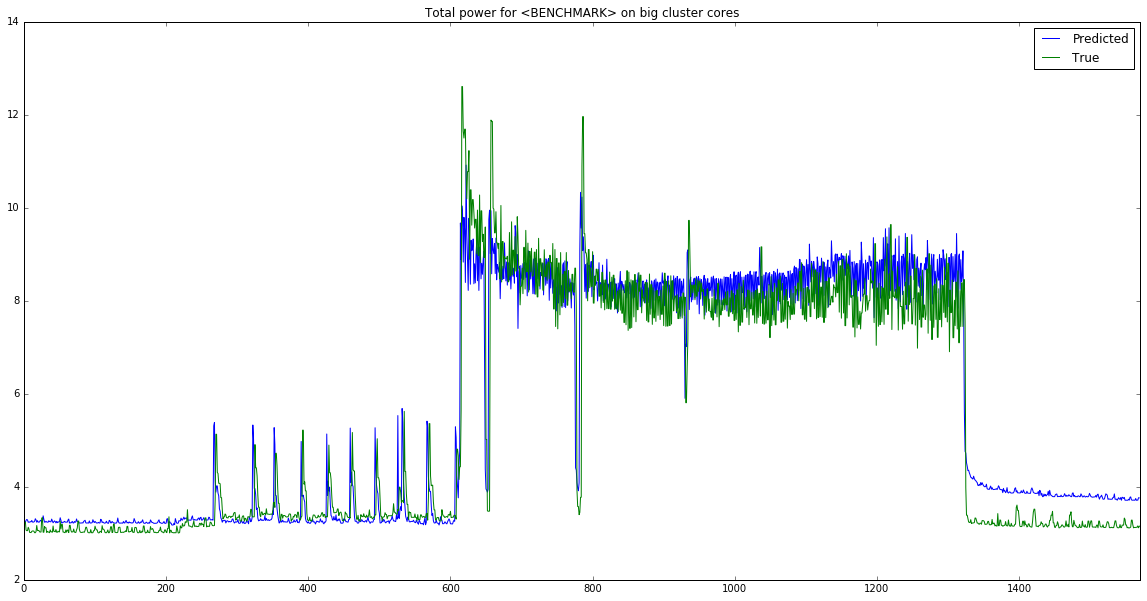

In [433]:
plt.rcParams["figure.figsize"] = [20,10]
plt.plot(range(len(P_plot)), P_plot, label="Predicted")
y_plot.plot(label="True")
plt.legend()
plt.title("Total power for <BENCHMARK> on big cluster cores")
plt.show()

In [451]:
X_hack = np.identity(X.shape[1])
model_coeffs = DPM.predict(X_hack)
print(model_coeffs)

#using from above:
# def leak_row_big(row):
# def leak_row_little(row):
# Defining now:
def dyn_row_big(row):
    global model_coeffs
    return row.aVVFb * model_coeffs[0] + row.vvf_b * model_coeffs[1]

def dyn_row_little(row):
    global model_coeffs
    return row.aVVFl * model_coeffs[2] + row.vvf_l * model_coeffs[3]

foo = pd.DataFrame(data=X_plot, columns = ["aVVFb", "vvf_b", "aVVFl", "vvf_l", "gpu_mem", "p_leak"])

[ 6.95454933  2.78515399  3.00094391  2.31650832  2.33122824  5.08199098]


In [452]:
dyn_power_est = pd.DataFrame()
# Estimate the dynamic power for the big cluster:
dyn_power_est['big_dyn'] = foo.apply(dyn_row_big, axis=1)
    
# Total power for big cluster is dynamic plus leakage:
dyn_power_est['big_tot'] = other_XY['leak_big'] + dyn_power_est['big_dyn']

In [453]:
# Estimate the dynamic power for the LITTLE cluster:
dyn_power_est['little_dyn'] = foo.apply(dyn_row_little, axis=1)

# Total power for LITTLE cluster is dynamic plus leakage:
dyn_power_est['little_tot'] = other_XY['leak_little'] + dyn_power_est['little_dyn']

In [454]:
dyn_power_est['little_dyn'].describe()

count    1.570000e+03
mean     4.085759e-02
std      2.203843e-01
min     -4.409248e-12
25%      9.861914e-03
50%      1.333871e-02
75%      2.318415e-02
max      3.677764e+00
Name: little_dyn, dtype: float64

In [455]:
dyn_power_est['big_dyn'].describe()

count    1.570000e+03
mean     2.616029e+00
std      2.775686e+00
min     -3.999793e-12
25%      3.440362e-02
50%      3.046890e-01
75%      5.530710e+00
max      9.804386e+00
Name: big_dyn, dtype: float64

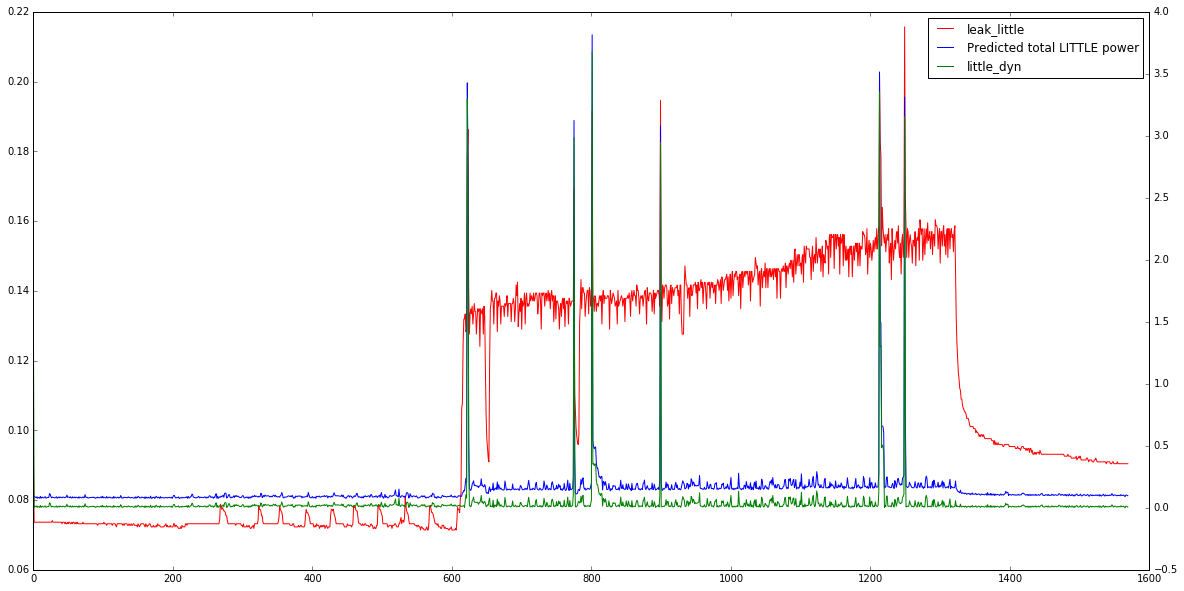

In [449]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.rcParams["figure.figsize"] = [20,10]

lns1 = ax1.plot(range(len(other_XY.leak_little)), other_XY.leak_little, 'r', label="leak_little")
ax2 = ax1.twinx()
lns2 = ax2.plot(range(len(dyn_power_est.little_tot)), dyn_power_est.little_tot, label="Predicted total LITTLE power")
lns3 = ax2.plot(range(len(dyn_power_est.little_dyn)), dyn_power_est.little_dyn, label="little_dyn")

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()

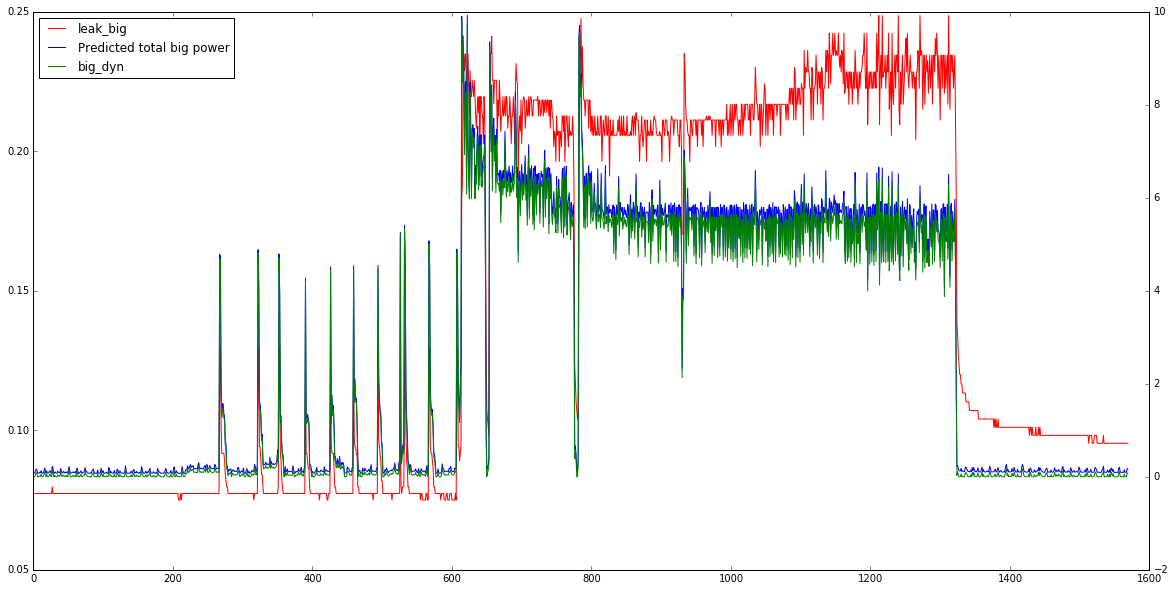

In [448]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.rcParams["figure.figsize"] = [20,10]

lns1 = ax1.plot(range(len(other_XY.leak_big)), other_XY.leak_big, 'r', label="leak_big")
ax2 = ax1.twinx()
lns2 = ax2.plot(range(len(dyn_power_est.big_tot)), dyn_power_est.big_tot, label="Predicted total big power")
lns3 = ax2.plot(range(len(dyn_power_est.big_dyn)), dyn_power_est.big_dyn, label="big_dyn")

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

plt.show()